# Proyecto 1: Entrega 1 - BI

| ID | Nombre           | Código    | Correo                       |
|----|------------------|-----------|------------------------------|
| 1  | Adrian Velasquez | 202222737 | a.velasquezs@uniandes.edu.co |
| 2  | Andres Molano    | 202215460       | a.molanob@uniandes.edu.co          |
| 3  | Sebastian Ramirez| 202123415     | s.ramirez112@uniandes.edu.co          |

In [609]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from nltk import SnowballStemmer, WordNetLemmatizer

import nltk
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn import tree

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Andres\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [610]:
TRAIN = "data/train_data.xlsx"
TEST = "data/test_data.xlsx"

## Entendimiento y perfilamiento de los datos

De forma preliminar, sabemos que el objetivo de nuestro modelo es categorizar las opiniones de acuerdo a los ODS (objetivos de desarrollo sostenible) 1, 3 y 4, los cuales son “Fin de la pobreza”, “Salud y bienestar” y “Educación de calidad” respectivamente. En primer lugar, haremos un análisis preliminar de los datos, la calidad de los mismos, y validaremos cualquier caso particular que encontremos.

In [611]:
df_original = pd.read_excel(TRAIN)
df_original.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [612]:
df_original.shape

(2424, 2)

In [613]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [614]:
print(df_original.isnull().sum())

textos    0
labels    0
dtype: int64


In [615]:
print(df_original.duplicated().sum())

0


Podemos ver una completitud en los datos, pues no hay nulos en ninguno de los entries en ninguna de las dos columnas. Asimismo, no hay duplicados completos, lo cual es una buena señal. Ahora nos centraremos a comprender cada columna por separado

### Columna textos

In [616]:
print(df_original["textos"].duplicated().sum())

0


Toca convertir la columna de textos a tipo string, con el fin de poderla manipular adecuadamente y hacer un análisis más riguroso.

In [617]:
df_original["textos"] = df_original["textos"].astype("string")
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   string
 1   labels  2424 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 38.0 KB


In [618]:
df_text_analysis = df_original.copy()

In [619]:
df_text_analysis["textos_lower"] = df_text_analysis["textos"].str.lower()
df_text_analysis.head()

,textos,labels,textos_lower
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"""aprendizaje"" y ""educación"" se consideran sinó..."
1,Para los niños más pequeños (bebés y niños peq...,4,para los niños más pequeños (bebés y niños peq...
2,"Además, la formación de especialistas en medic...",3,"además, la formación de especialistas en medic..."
3,En los países de la OCDE se tiende a pasar de ...,4,en los países de la ocde se tiende a pasar de ...
4,Este grupo se centró en las personas que padec...,3,este grupo se centró en las personas que padec...


In [620]:
print(df_text_analysis["textos_lower"].duplicated().sum())

0


Podemos ver que incluso cuando todas las entries de la columna han sido normalizadas de tal manera que están en minúscula, no hay duplicados entre ellas.

In [621]:
df_text_analysis["textos_lower_split"] = df_text_analysis["textos_lower"].str.replace("(","").str.replace(")","").str.replace('"', "").str.replace(",","").str.split(" ")
df_text_analysis.head()

,textos,labels,textos_lower,textos_lower_split
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"""aprendizaje"" y ""educación"" se consideran sinó...","[aprendizaje, y, educación, se, consideran, si..."
1,Para los niños más pequeños (bebés y niños peq...,4,para los niños más pequeños (bebés y niños peq...,"[para, los, niños, más, pequeños, bebés, y, ni..."
2,"Además, la formación de especialistas en medic...",3,"además, la formación de especialistas en medic...","[además, la, formación, de, especialistas, en,..."
3,En los países de la OCDE se tiende a pasar de ...,4,en los países de la ocde se tiende a pasar de ...,"[en, los, países, de, la, ocde, se, tiende, a,..."
4,Este grupo se centró en las personas que padec...,3,este grupo se centró en las personas que padec...,"[este, grupo, se, centró, en, las, personas, q..."


In [622]:
df_text_analysis["len_texts"] = df_text_analysis["textos_lower_split"].str.len()

df_text_analysis["len_texts"].describe()

count    2424.000000
mean      107.953795
std        35.578358
min        41.000000
25%        81.000000
50%       102.000000
75%       129.000000
max       260.000000
Name: len_texts, dtype: float64

In [623]:
df_text_analysis.shape

(2424, 5)

In [624]:
print(len(df_text_analysis["len_texts"].unique()))

184


### Columna label (target)

In [625]:
df_original['labels'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2424 entries, 0 to 2423
Series name: labels
Non-Null Count  Dtype
--------------  -----
2424 non-null   int64
dtypes: int64(1)
memory usage: 19.1 KB


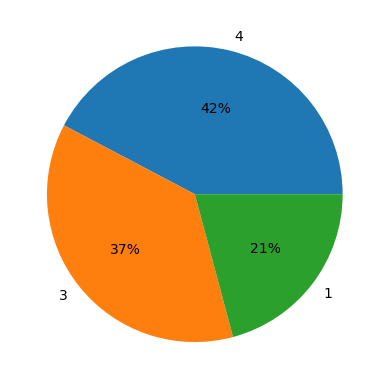

In [626]:
plt.pie(df_original['labels'].value_counts(), labels=df_original['labels'].unique(), autopct='%1.0f%%')
plt.show()

### Duplicados parciales

En general, no se observaron duplicados parciales. Hay textos cuya longitud es equivalente, sin embargo, no son idénticos.

## Preparación de los datos

En esta etapa, vamos a definir ciertas funciones y demás herramientas que serán útiles a la hora de desarrollar los modelos.

In [627]:
df = df_original.copy()
df.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


Ahora que tenemos un dataframe sobre el cual podemos trabajar, ejecutaremos un TfidVectorizer para garantizar que las palabras tokenizadas sean adecuadamente analizadas con base en en el TF-IDF, para medir la importancia de ciertas palabras en comparación a los demás textos. A este TfidVectorizer le agregaremos un Stemmer para minimizar la redundancia de las palabras que vamos a analizar. Utilizaremos también un conjunto de StopWords en español que ofrece la librería NLTK, la cual también pasaremos por el Stemmer para garantizar que ningún StopWord quede en el conjunto final de palabras escogidas.

In [628]:
from nltk import word_tokenize
import re

spanish_sw = list(stopwords.words("spanish"))
# Se utilizó un stemmer debido a que no hay un Lemmatizer en español disponible en la librería NLTK
stemmer = SnowballStemmer(language="spanish")

otras_palabras = ["tambien"]

spanish_sw.extend(otras_palabras)

# Tokenizador utilizando stemming
def stemmed_tokenizer(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

nuevas_stopwords = [stemmer.stem(token) for token in spanish_sw]

spanish_sw.extend(nuevas_stopwords) # agregar los stopwords lematizados a los stopwords originales

# Limpiar los textos antes de nada
def clean_text(s):
    s = s.replace("\n", " ").replace("(", " ").replace(")", " ").replace(",", " ").replace(".", " ").replace("?", " ").replace("!", " ").replace("'", " ")
    s = s.lower()
    s = re.sub(r'\d+', ' ', s)
    s = re.sub(r'[^\w]', ' ', s)
    return s


tfidf_word = TfidfVectorizer(
    preprocessor=clean_text,
    tokenizer=stemmed_tokenizer,
    stop_words=spanish_sw,
    max_df=0.9,
    min_df=3,
    max_features=10_000,
    token_pattern=None
)

Más allá del vectorizer, como vimos en el entendimiento y perfilamiento de los datos, no hay mucho que hacer antes de seguir con la construcción de los modelos. Para tener una idea de cómo quedarán las palabras escogidas por el TF-IDF Vectorizer, lo utilizaremos a continuación

In [629]:
tfidf_matrix = tfidf_word.fit_transform(df_original['textos'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_word.get_feature_names_out())

tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Columns: 3081 entries, abaj to â
dtypes: float64(3081)
memory usage: 57.0 MB


In [630]:
print(  f"Ejemplos de palabras escogidas por el TF-IDF Vectorizer: {tfidf_df.columns.tolist()[0:100]}" )

Ejemplos de palabras escogidas por el TF-IDF Vectorizer: ['abaj', 'abandon', 'abarc', 'abiert', 'abog', 'abol', 'abord', 'abordaj', 'aborigen', 'abort', 'abriend', 'abril', 'absolut', 'absorb', 'abus', 'acab', 'academ', 'acced', 'acces', 'accesibil', 'accident', 'accion', 'ace', 'aceler', 'acept', 'acerc', 'acert', 'aclar', 'acog', 'acomod', 'acompañ', 'aconsej', 'acontec', 'acord', 'acredit', 'actitud', 'activ', 'actor', 'actu', 'actual', 'actualiz', 'acud', 'acuerd', 'acumul', 'ad', 'adapt', 'ade', 'adecu', 'adel', 'adelant', 'ademas', 'adiccion', 'adicional', 'administr', 'admision', 'admit', 'adolescent', 'adopcion', 'adopt', 'adpic', 'adquier', 'adquir', 'adquisicion', 'adquisit', 'adult', 'advers', 'advertent', 'aepi', 'afeccion', 'afect', 'afganistan', 'afili', 'afin', 'afirm', 'afl', 'afric', 'african', 'afroamerican', 'agenci', 'agend', 'agent', 'agost', 'agradec', 'agrav', 'agreg', 'agricol', 'agricultur', 'agrup', 'agu', 'agud', 'ahor', 'ahorr', 'aihw', 'aimag', 'aimags', 'a

Antes de continuar, recordemos que el objetivo del TF-IDF Vectorizer es medir la importancia de cada una de las palabras en cada uno de los documentos en relación a los demás documentos. Esto ayudará a los clasificadores (modelos) a clasificar de forma efectiva cada documento.

## Construcción de los modelos

### Preparación inicial

En general, debido a que en el vectorizer incluimos un preprocesador para la limpieza de los textos y la eliminación de los stopwords, no es necesario hacer muchos procedimientos de forma manual.

In [631]:
x = df["textos"]
y = df["labels"]

x_train, x_test, y_train, y_test = train_test_split(x, y)

### Modelo 1: LinearSVC

El primer modelo que utilizaremos es el LinearSVC, pues es un modelo estándar de la librería SciKit Learn que es utilizado para tareas de clasificación.

Más allá de las recomendaciones de SciKit Learn que sugieren utilizar este algoritmo para la clasificación de textos, escogimos este modelo principalmente por su capacidad de evaluar relaciones lineales.

In [632]:
pipe_linear_svm = Pipeline([
    ("vector", tfidf_word),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])

In [633]:
pipe_linear_svm.fit(x_train, y_train)

Pipeline(steps=[('vector',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=3,
                                 preprocessor=<function clean_text at 0x0000025274BE0540>,
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...],
                                 token_pattern=None,
                                 tokenizer=<function stemmed_tokenizer at 0x0000025274BE0CC0>)),
                ('clf', LinearSVC(class_weight='balanced', random_state=42))])

In [634]:
pred_linear_svm = pipe_linear_svm.predict(x_test)

In [635]:
cm_linear_svm = confusion_matrix(y_test, pred_linear_svm)

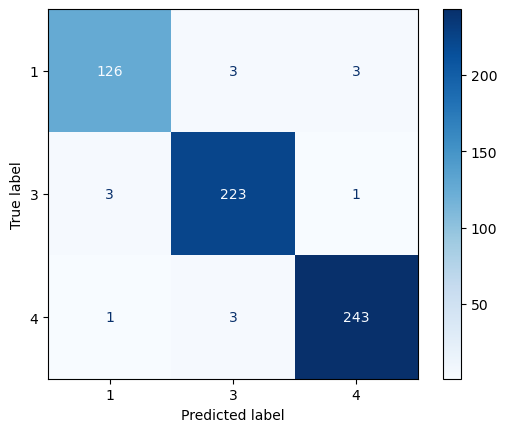

In [636]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_linear_svm, display_labels=pipe_linear_svm.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [637]:
print(classification_report(y_test, pred_linear_svm))

              precision    recall  f1-score   support

           1       0.97      0.95      0.96       132
           3       0.97      0.98      0.98       227
           4       0.98      0.98      0.98       247

    accuracy                           0.98       606
   macro avg       0.98      0.97      0.97       606
weighted avg       0.98      0.98      0.98       606



Con base en la matriz de confusión y las métricas del reporte de clasificación, podemos concluir que el modelo LinearSVC será un modelo útil a la hora de abordar el problema.

### Modelo 2: DecisionTreeClassifier

El segundo modelo que utilizaremos será el DecisionTreeClassifier, pues es un modelo que trabajamos en clase y puede ser aplicado en este contexto.

Este modelo, como otros árboles de decisión, es comúnmente utilizado para encontrar patrones no lineales entre los conjuntos de datos. Escogimos este algoritmo para efectuar un análisis distinto de los datos, la cual contrasta especialmente con el algoritmo de LinearSVC. Entendemos que este algoritmo es ideal para trabajar tanto variables numéricas como categóricas, y en este ejercicio realmente solo estamos trabajando con texto, pero, como dicho anteriormente, el fuerte de los árboles de decisión es encontrar relaciones no lineales, y eso es algo que los demás algoritmos escogidos no trabajan igual de bien.

In [638]:
pipe_dec_tree = Pipeline([
    ("vector", tfidf_word),
    ("clf", DecisionTreeClassifier(random_state=42,class_weight="balanced"))
])

In [639]:
pipe_dec_tree.fit(x_train, y_train)

Pipeline(steps=[('vector',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=3,
                                 preprocessor=<function clean_text at 0x0000025274BE0540>,
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...],
                                 token_pattern=None,
                                 tokenizer=<function stemmed_tokenizer at 0x0000025274BE0CC0>)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [640]:
pred_dec_tree = pipe_dec_tree.predict(x_test)

In [641]:
cm_dec_tree = confusion_matrix(y_test, pred_dec_tree)

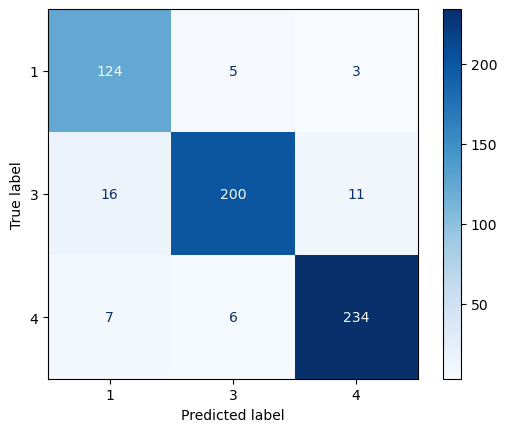

In [642]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree, display_labels=pipe_dec_tree.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [643]:
print(classification_report(y_test, pred_dec_tree))

              precision    recall  f1-score   support

           1       0.84      0.94      0.89       132
           3       0.95      0.88      0.91       227
           4       0.94      0.95      0.95       247

    accuracy                           0.92       606
   macro avg       0.91      0.92      0.92       606
weighted avg       0.92      0.92      0.92       606



Con base en la matriz de confusión y las métricas del reporte de clasificación, podemos concluir que el modelo DecisionTreeClassifier será un modelo útil a la hora de abordar el problema. Cabe resaltar que en general, las métricas fueron inferiores a las obtenidas en el modelo LinearSVC, sin embargo, al modificar los parámetros podríamos obtener resultados más precisos. A continuación se mostrará una representación gráfica del árbol de decision generado.

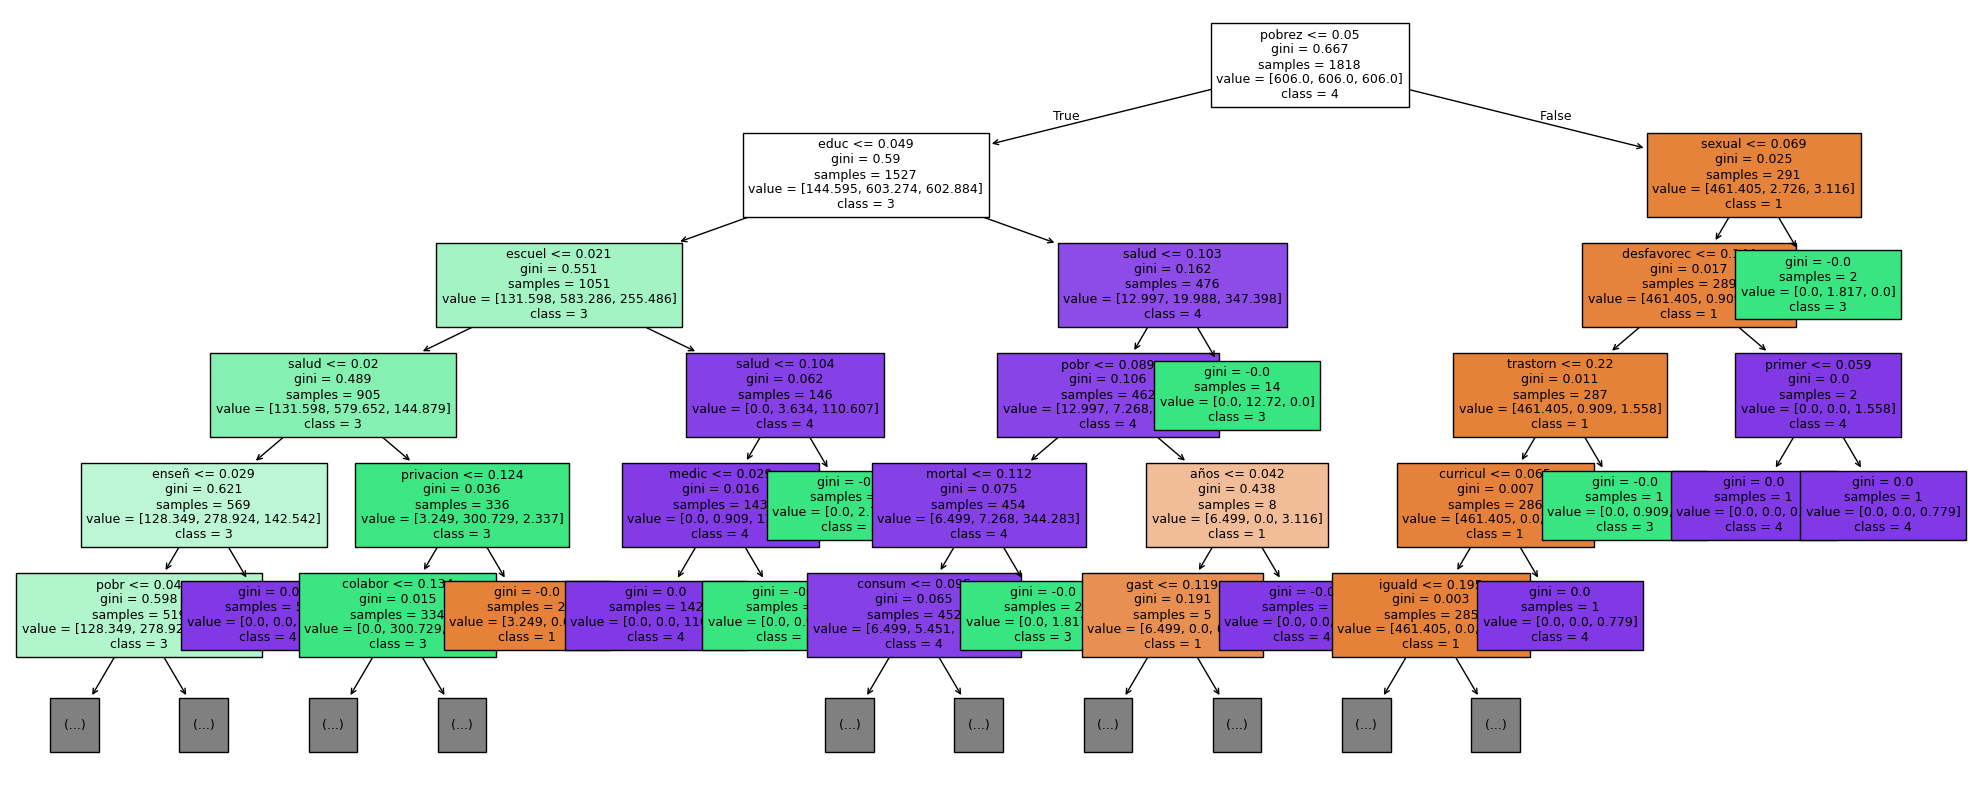

In [644]:
dec_tree = pipe_dec_tree.named_steps["clf"]
tfidf_vectorizer = pipe_dec_tree.named_steps["vector"]

fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dec_tree, max_depth=5 if dec_tree.tree_.max_depth > 5 else 2, feature_names=tfidf_vectorizer.get_feature_names_out(), class_names=["1", "3", "4"], filled=True, fontsize=9)

### Modelo 3: Complement Naive Bayes

El tercer modelo que utilizaremos será el de ComplementNaiveBayes, el cual se basa en el teorema de Bayes. Este modelo también es estándar en la librería de SciKit Learn. De acuerdo al diagrama de guía que provee SciKit Learn, que se puede encontrar en `documents/sklearn_model_cheat_sheet.jpeg` y en la página oficial de la librería, este modelo (Naive Bayes) debería ser utilizado en caso de que el modelo LinearSVC no haya funcionado.

El funcionamiento del algoritmo de ComplementNaiveBayes es muy similar al de los algoritmos MultinomialNaiveBayes o similares. La diferencia radica en que en vez de basarse en la probabilidad de que un elemento pertenezca a una clase, se basa en la probabilidad de que un elemento _no_ pertenezca a una clase, para que la decisión final sea en torno a la clase cuya probabilidad de que el elemento no pertenezca sea menor. Decidimos utilizarlo para contrastar con los otros algoritmos seleccionados, pues a diferencia de aquellos, este algoritmo trabaja sobre probabilidades.

In [645]:
pipe_comp_nb = Pipeline([
    ("vector", tfidf_word),
    ("clf", ComplementNB())
])

In [646]:
pipe_comp_nb.fit(x_train, y_train)

Pipeline(steps=[('vector',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=3,
                                 preprocessor=<function clean_text at 0x0000025274BE0540>,
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...],
                                 token_pattern=None,
                                 tokenizer=<function stemmed_tokenizer at 0x0000025274BE0CC0>)),
                ('clf', ComplementNB())])

In [647]:
pred_comb_nb = pipe_comp_nb.predict(x_test)

In [648]:
cm_comp_nb = confusion_matrix(y_test, pred_comb_nb)

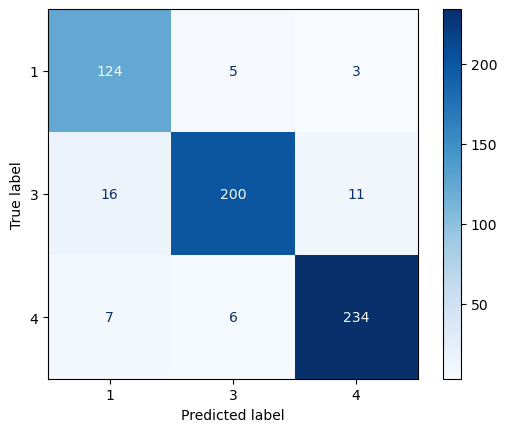

In [649]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree, display_labels=pipe_comp_nb.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [650]:
print(classification_report(y_test, pred_comb_nb))

              precision    recall  f1-score   support

           1       0.92      0.98      0.95       132
           3       1.00      0.96      0.98       227
           4       0.98      0.98      0.98       247

    accuracy                           0.97       606
   macro avg       0.97      0.97      0.97       606
weighted avg       0.97      0.97      0.97       606



Con base en la matriz de confusión y las métricas del reporte de clasificación, podemos concluir que el modelo ComplementNaiveBayes será un modelo útil a la hora de abordar el problema. Podemos observar que las métricas son muy similares a las obtenidas por el modelo LinearSVC, y en general son muy satisfactorias.

### Búsqueda de parámetros

Pese a que los resultados de los 3 modelos en general fueron satisfactorios, intentaremos mejorarlos aún más utilizando GridSearchCV con el fin de garantizar un modelo todavía mejor. Se definiran los grids de parámetros para cada uno, y posteriormente los compararemos entre sí para utilizar el mejor entre todos.

In [651]:
cv_tree = KFold(n_splits=10, shuffle=True, random_state = 0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "f1_macro"

Definimos los parámetros apoyándonos en la documentación que ofrece SciKit Learn, al igual que los ejemplos vistos en clase.

In [652]:
param_svm = {"clf__C": [0.1, 0.3, 0.5, 1, 2, 3]}
param_tree = {'clf__criterion':['gini', 'entropy'],'clf__max_depth':[4,6,8,10,20,50]}
param_nb  = {"clf__alpha": [0.1, 0.3, 0.5, 1.0, 2.0, 3.0]}

Los parámetros de cada uno de los modelos son los siguientes:

1. Modelo 1 - LinearSVC
    - C: Controla la inclusión de outliers. A mayor C, menos outliers, y un menor C implica más outliers siendo evaluados.
2. Modelo 2 - DecisionTreeClassifier
    - Criterion: Determina la estrategia utilizada para evaluar la "pureza" de la división en los nodos de del árbol.
    - Max Depth: Determina la profundidad máxima del árbol
3. Modelo 3 - ComplementNaiveBayes
    - Alpha: Parámetro para calibrar el aislamiento aditivo (Es decir ayuda en aquellos casos donde no hayan ocurrencias de algún caso). Mayor alpha, mayor aislamiento

In [653]:
mejor_pipe_linear_svm = GridSearchCV(
    estimator=pipe_linear_svm,
    param_grid=param_svm,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1,
)
mejor_pipe_linear_svm.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('vector',
                                        TfidfVectorizer(max_df=0.9,
                                                        max_features=10000,
                                                        min_df=3,
                                                        preprocessor=<function clean_text at 0x0000025274BE0540>,
                                                        stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
                                                                    'como',
                                                                    'más',
                                                                    'pero',
                                                                    'sus', 'le',
                                                                    'ya', 'o',
                                                                    'este',
                                                                    'sí',
                                                                    'porque', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function stemmed_tokenizer at 0x0000025274BE0CC0>)),
                                       ('clf',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=42))]),
             n_jobs=-1, param_grid={'clf__C': [0.1, 0.3, 0.5, 1, 2, 3]},
             scoring='f1_macro', verbose=1)

In [654]:
mejor_pipe_dec_tree = GridSearchCV(
    estimator=pipe_dec_tree,
    param_grid=param_tree,
    scoring=scoring,
    cv=cv_tree,
    n_jobs=-1,
    verbose=1
)
mejor_pipe_dec_tree.fit(x_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('vector',
                                        TfidfVectorizer(max_df=0.9,
                                                        max_features=10000,
                                                        min_df=3,
                                                        preprocessor=<function clean_text at 0x0000025274BE0540>,
                                                        stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
                                                                    'como',
                                                                    'más',
                                                                    'pero',
                                                                    'sus', 'le',
                                                                    'ya', 'o',
                                                                    'este',
                                                                    'sí',
                                                                    'porque', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function stemmed_tokenizer at 0x0000025274BE0CC0>)),
                                       ('clf',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [4, 6, 8, 10, 20, 50]},
             scoring='f1_macro', verbose=1)

### Selección del mejor modelo

In [655]:
mejor_pipe_comp_nb = GridSearchCV(
    estimator=pipe_comp_nb,
    param_grid=param_nb,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
mejor_pipe_comp_nb.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('vector',
                                        TfidfVectorizer(max_df=0.9,
                                                        max_features=10000,
                                                        min_df=3,
                                                        preprocessor=<function clean_text at 0x0000025274BE0540>,
                                                        stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
                                                                    'como',
                                                                    'más',
                                                                    'pero',
                                                                    'sus', 'le',
                                                                    'ya', 'o',
                                                                    'este',
                                                                    'sí',
                                                                    'porque', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function stemmed_tokenizer at 0x0000025274BE0CC0>)),
                                       ('clf', ComplementNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 0.3, 0.5, 1.0, 2.0, 3.0]},
             scoring='f1_macro', verbose=1)

In [656]:
def summarize(gs, name):
    df_temp = pd.DataFrame(gs.cv_results_)
    cols = ["mean_test_score", "std_test_score", "params", "rank_test_score"]
    out = df_temp[cols].sort_values("rank_test_score").copy()
    out.insert(0, "modelo", name)
    return out

In [657]:
tbl = pd.concat([
    summarize(mejor_pipe_linear_svm, "LinearSVC"),
    summarize(mejor_pipe_dec_tree, "DecTree"),
    summarize(mejor_pipe_comp_nb, "ComplNB")
], ignore_index=True)

tbl = tbl.sort_values("mean_test_score", ascending=False)

display(tbl.head(10))

best_global = max(
    [("LinearSVC", mejor_pipe_linear_svm), ("DecTree", mejor_pipe_dec_tree), ("ComplNB", mejor_pipe_comp_nb)],
    key=lambda t: t[1].best_score_
)
best_name, best_gs = best_global
print("Mejor modelo:", best_name, " | F1-macro CV:", round(best_gs.best_score_, 4))
print("Mejores params:", best_gs.best_params_)

,modelo,mean_test_score,std_test_score,params,rank_test_score
0,LinearSVC,0.974778,0.005477,{'clf__C': 0.5},1
1,LinearSVC,0.974730,0.005433,{'clf__C': 0.3},2
2,LinearSVC,0.973404,0.005149,{'clf__C': 1},3
3,LinearSVC,0.971810,0.005638,{'clf__C': 2},4
4,LinearSVC,0.971341,0.006204,{'clf__C': 3},5
5,LinearSVC,0.969172,0.003305,{'clf__C': 0.1},6
18,ComplNB,0.962195,0.007956,{'clf__alpha': 2.0},1
19,ComplNB,0.961795,0.005152,{'clf__alpha': 1.0},2
20,ComplNB,0.960905,0.010982,{'clf__alpha': 3.0},3
21,ComplNB,0.958248,0.008297,{'clf__alpha': 0.3},4


Mejor modelo: LinearSVC  | F1-macro CV: 0.9748
Mejores params: {'clf__C': 0.5}


Con base en estos resultados, utilizaremos el mejor modelo de ahora en adelante.

In [658]:
pipe_best = mejor_pipe_linear_svm.best_estimator_
pipe_best.fit(x_train, y_train) # garantizar que el modelo se entrene apropiadamente
pred_best = pipe_best.predict(x_test)

print(classification_report(y_test, pred_best))

              precision    recall  f1-score   support

           1       0.97      0.95      0.96       132
           3       0.97      0.98      0.98       227
           4       0.98      0.98      0.98       247

    accuracy                           0.98       606
   macro avg       0.98      0.97      0.97       606
weighted avg       0.98      0.98      0.98       606



In [659]:
MODEL = "models/modelo.joblib"
joblib.dump(pipe_best, MODEL)
print(f"Mejor modelo guardado en {MODEL}")

Mejor modelo guardado en models/modelo.joblib


## Etiquetamiento del conjunto de prueba

Ya que tenemos el modelo definido, lo caragremos y lo utilizaremos para etiquetar el conjunto de datos de prueba, el cual no está etiquetado.

In [660]:
model = joblib.load(MODEL)
print(f"Modelo cargado de {MODEL}")

Modelo cargado de models/modelo.joblib


In [661]:
unlabeled_data = pd.read_excel(TEST)
unlabeled_data.head()

,Textos_espanol
0,"El rector, que es el representante local del M..."
1,Tenga en cuenta que todos los programas antipo...
2,"Debido a que son en gran medida invisibles, es..."
3,Los recursos aún son limitados en este sector....
4,"Durante el período 1985-2008, la educación pri..."


In [662]:
unlabeled_data.shape

(152, 1)

In [663]:
unlabeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  152 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


Convertiremos la columna de Textos_espanol a tipo string para garantizar un análisis correcto, y cambiaremos el nombre a "textos" para simplificar un poco el dataframe.

In [664]:
unlabeled_data["textos"] = unlabeled_data["Textos_espanol"].astype("string")
unlabeled_data = unlabeled_data.drop(columns=["Textos_espanol"])
unlabeled_data.shape

(152, 1)

In [665]:
unlabeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  152 non-null    string
dtypes: string(1)
memory usage: 1.3 KB


Ahora extraemos los textos del dataframe y los etiquetamos utilizando el modelo

In [666]:
x_unlabeled = unlabeled_data["textos"]
labels = model.predict(x_unlabeled)
print(f"Tamaño del array de labels: {len(labels)}")

Tamaño del array de labels: 152


In [667]:
labeled_data = unlabeled_data.copy()
labeled_data["labels"] = labels.copy()
labeled_data.head()

,textos,labels
0,"El rector, que es el representante local del M...",4
1,Tenga en cuenta que todos los programas antipo...,3
2,"Debido a que son en gran medida invisibles, es...",1
3,Los recursos aún son limitados en este sector....,3
4,"Durante el período 1985-2008, la educación pri...",4


In [668]:
labeled_data.shape

(152, 2)

In [669]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  152 non-null    string
 1   labels  152 non-null    int64 
dtypes: int64(1), string(1)
memory usage: 2.5 KB


Una vez etiquetados los datos, los guardamos en un archivo distinto en el directorio de datos.

In [670]:
LABELED_DATA = "data/labeled_test_data.xlsx"
labeled_data.to_excel(LABELED_DATA, index=False)
print(f"Datos de prueba con labels guardado en {LABELED_DATA}")

Datos de prueba con labels guardado en data/labeled_test_data.xlsx


## Resultados

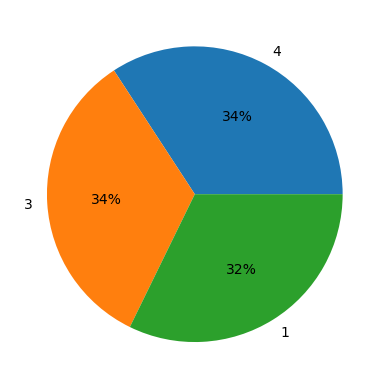

In [671]:
plt.pie(labeled_data['labels'].value_counts(), labels=labeled_data['labels'].unique(), autopct='%1.0f%%')
plt.show()

In [672]:
tfidf_vectorizer = model.named_steps["vector"]
selected_words = tfidf_vectorizer.get_feature_names_out().tolist()
print( f"Ejemplos de las palabras escogidas en el mejor modelo:\n{selected_words[0:15]}" )
print( f"\nEjemplos de las palabras escogidas en el mejor modelo:\n{selected_words[-15:]}" )

Ejemplos de las palabras escogidas en el mejor modelo:
['abaj', 'abandon', 'abarc', 'abiert', 'abog', 'abol', 'abord', 'abort', 'abril', 'absolut', 'absorb', 'abus', 'acab', 'academ', 'acced']

Ejemplos de las palabras escogidas en el mejor modelo:
['voluntari', 'volv', 'voz', 'vuelt', 'vuelv', 'vulner', 'washington', 'web', 'www', 'x', 'xix', 'xx', 'zeland', 'zon', 'º']


In [673]:
len(selected_words)

2682

Podemos ver que en el modelo final, se escogieron alrededor de 2677 palabras distintas, las cuales fueron lemmatizadas y posteriormete vectorizadas utilizando el algoritmo de TF-IDF. El objetivo de esto es simplificar el análisis reduciendo la cantidad de palabras (con el lemmatizador) y dar un índice relativo a la importancia de cada token en cada texto (con el tf-idf vectorizer). El resultado, como visto anteriormente en la sección de preparación inicial de los datos, es una matriz donde cada una de las filas representa un texto particular i, y las columnas son las palabras j que se encuentran en el documento. El valor en (i,j) es entonces el índice TF-IDF de la palabra j en el texto i, el cual mide la importancia de la palabra en relación a todos los textos.

# En resumen :
En este proyecto se entrenaron y compararon tres modelos supervisados para la categorización de opiniones según los ODS 1 (Fin de la pobreza), 3 (Salud y bienestar) y 4 (Educación de calidad):

**LinearSVC**

**DecisionTreeClassifier**

**Complement Naive Bayes**

El modelo seleccionado como mejor fue LinearSVC, ya que obtuvo el mayor puntaje de f1-score macro durante la validación cruzada (aproximadamente 0.98).
Las métricas de calidad evaluadas fueron: precisión, recall y f1-score para cada clase, además del promedio macro.
Esto significa que el modelo logra identificar correctamente la mayoría de las opiniones y asignarlas al ODS correspondiente, minimizando tanto los falsos positivos como los falsos negativos.

**¿Por qué es útil para la organización?**
Un alto f1-score indica que el modelo es confiable para automatizar la clasificación de opiniones, permitiendo a la organización analizar grandes volúmenes de texto y tomar decisiones informadas sobre el impacto y percepción de sus acciones en cada ODS.

El siguiente código muestra las métricas de calidad del modelo seleccionado. Estas métricas permiten evaluar la capacidad del modelo para clasificar correctamente las opiniones según cada ODS. Un alto f1-score macro indica que el modelo es robusto y confiable para apoyar la toma de decisiones y el análisis automatizado de grandes volúmenes de opiniones, alineándose con los objetivos estratégicos de la organización.

Reporte de clasificación (precision, recall, f1-score):
              precision    recall  f1-score   support

           1       0.97      0.95      0.96       132
           3       0.97      0.98      0.98       227
           4       0.98      0.98      0.98       247

    accuracy                           0.98       606
   macro avg       0.98      0.97      0.97       606
weighted avg       0.98      0.98      0.98       606



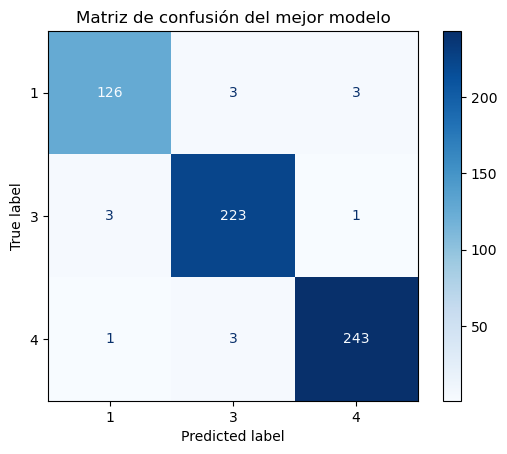

In [674]:
# Mostrar reporte de métricas de calidad para el mejor modelo

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# pred_best ya contiene las predicciones del mejor modelo sobre el conjunto de prueba
print("Reporte de clasificación (precision, recall, f1-score):")
print(classification_report(y_test, pred_best))

# Matriz de confusión
disp = ConfusionMatrixDisplay.from_estimator(
    pipe_best, x_test, y_test, display_labels=pipe_best.classes_, cmap=plt.cm.Blues
)
plt.title("Matriz de confusión del mejor modelo")
plt.show()

Como se habia mencionado El modelo utiliza un vectorizador TF-IDF con stemming y stopwords en español, lo que permite identificar las palabras más relevantes para cada ODS.
Por ejemplo, palabras como “pobreza”, “salud”, “educación”, “acceso”, “servicios”, “calidad”, “bienestar”, etc., fueron seleccionadas como importantes.

El siguiente código muestra las palabras más relevantes que el modelo asocia con cada ODS. Estas palabras pueden ser usadas para monitorear tendencias, diseñar campañas focalizadas y priorizar intervenciones, ya que reflejan los temas que más inciden en la percepción pública sobre cada objetivo

In [675]:
# Mostrar las palabras más relevantes para cada ODS según LinearSVC

import numpy as np

vectorizer = pipe_best.named_steps["vector"]
clf = pipe_best.named_steps["clf"]

feature_names = np.array(vectorizer.get_feature_names_out())
for i, ods in enumerate(clf.classes_):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print(f"ODS {ods} - Palabras más relevantes:")
    print(feature_names[top10][::-1])
    print()

ODS 1 - Palabras más relevantes:
['pobrez' 'pobr' 'privacion' 'ingres' 'hogar' 'proteccion' 'social'
 'viviend' 'transferent' 'dimension']

ODS 3 - Palabras más relevantes:
['salud' 'medic' 'sanitari' 'atencion' 'pacient' 'mortal' 'drog' 'mental'
 'enfermedad' 'medicament']

ODS 4 - Palabras más relevantes:
['educ' 'escuel' 'estudi' 'profesor' 'alumn' 'docent' 'aprendizaj' 'habil'
 'enseñ' 'escolar']




### Estrategias :

**Monitoreo Temático**: Analizar las palabras más frecuentes y relevantes para cada ODS permite identificar tendencias, preocupaciones y oportunidades de mejora en la percepción pública.

**Comunicación Focalizada**: Utilizar las palabras clave identificadas para diseñar campañas de comunicación más efectivas y alineadas con las preocupaciones reales de la población.

**Priorización de Intervenciones**: Si se detectan palabras asociadas a necesidades no cubiertas o problemáticas recurrentes, la organización puede priorizar acciones en esos temas.


### Justificación:
Esta información es útil porque permite a la organización entender no solo la clasificación, sino también el “porqué” detrás de cada asignación, facilitando la toma de decisiones basada en datos y el diseño de estrategias más efectivas.



## Trabajo en equipo

El trabajo se realizó en equipo siguiendo una metodología colaborativa, asignando roles y tareas específicas a cada integrante, además de realizar reuniones de planeación, ideación, seguimiento y finalización.



##  **Roles y tareas de los integrantes:**


- **Adrián Velásquez** (Líder de proyecto y líder de analítica): Coordinó la planeación del proyecto, definió las fechas de entregas intermedias y lideró la reunión de lanzamiento. Se encargó de consolidar los entregables y subir la entrega final. Además, gestionó la construcción de los modelos analíticos, evaluó las métricas de desempeño y garantizó que se seleccionara el mejor modelo. Dedicó aproximadamente 20 horas al proyecto.

- **Andrés Molano** (Líder de datos): Se encargó de la gestión de los datos, asegurando su limpieza, preparación y almacenamiento en el repositorio del grupo. Fue responsable de aplicar transformaciones de texto (tokenización, stopwords y lematización), así como de dejar disponible el dataset procesado para los demás integrantes. Dedicó aproximadamente 8 horas al proyecto.

- **Sebastián Ramírez** (Líder de negocio): Fue responsable de mantener la alineación del proyecto con los objetivos del UNFPA y la Agenda 2030, redactando los apartados relacionados con el entendimiento del problema y el impacto esperado. También apoyó la interpretación de resultados para proponer estrategias de uso de los modelos. Dedicó aproximadamente 12 horas al proyecto.

## **Algoritmos trabajados por cada integrante:**
- **Adrián Velásquez**: DecisionTreeClassifier y LinearSVM.

- **Andrés Molano**: Naive Bayes.

- **Sebastián Ramírez**: CounterVector.

## *Retos enfrentados*:

El grupo enfrentó el reto de equilibrar las clases de los datos, ya que los ODS estaban desbalanceados. Esto se resolvió mediante técnicas de preprocesamiento y selección de métricas adecuadas (f1-score). Otro reto fue la selección de algoritmos comparables, que se superó discutiendo en reuniones de seguimiento. Además, se utilizó ChatGPT como apoyo para obtener explicaciones de conceptos, generar ejemplos de código para limpieza de texto y comparar enfoques de modelado.

**Distribución de puntos (100 en total):**

- Adrián Velásquez: 40 puntos (mayor carga de liderazgo y análisis).

- Andrés Molano: 30 puntos.

- Sebastián Ramírez: 30 puntos.

**Puntos a mejorar**:
Para la siguiente entrega se deben mejorar la documentación del proceso de preprocesamiento y justificación de algoritmos, así como mantener un mayor número de reuniones de seguimiento cortas para garantizar un avance más balanceado entre todos los integrantes.